In [1]:
import pandas as pd
import h5py
import numpy as np
import glob
import cartopy.crs as ccrs
import pyart
from cartopy import geodesic
import shapely
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
import xarray as xr
from matplotlib.lines import Line2D
import seaborn as sns

def remove_suspect_gusts(df):
    #Include removal of Kurnell tornado
    dts = ["2010-12-14 07:03:00","2011-01-11 03:49:00","2015-12-15 23:33:00","2020-02-09 01:00:00","2020-02-09 03:18:00","2020-05-25 06:11:00",
          "2012-11-02 18:58:00","2012-12-20 21:19:00","2012-12-15 13:00:00","2012-12-29 16:15:00","2012-12-30 06:25:00","2012-12-30 18:01:00","2013-01-02 08:15:00",
          "2013-01-05 03:36:00","2013-01-12 15:22:00","2013-02-11 07:56:00"]
    return df[np.in1d(df.dt_utc,dts,invert=True)]

def read_stn_info(state):

        names = ["id", "stn_no", "district", "stn_name", "site_open", "site_close", "lat", "lon", "latlon_method", "state",\
                        "hgt_asl", "hgt_asl_baro", "wmo_idx", "y1", "y2", "comp%", "Y%", "N%", "W%", "S%", "I%", "#"]
        if state=="vic_nsw":
                stn_df1 = pd.read_csv(glob.glob("/g/data/eg3/ab4502/ExtremeWind/obs/aws/vic_one_min_gust/HD01D_StnDet_*.txt")[0],\
                    names=names, header=0)
                stn_df2 = pd.read_csv(glob.glob("/g/data/eg3/ab4502/ExtremeWind/obs/aws/nsw_one_min_gust/HD01D_StnDet_*.txt")[0],\
                    names=names, header=0)
                stn_df = pd.concat([stn_df1, stn_df2], axis=0)
        elif state=="nt":
                stn_df = pd.concat([pd.read_csv(f, names=names, header=None) for f in glob.glob("/g/data/eg3/ab4502/ExtremeWind/obs/aws/nt_one_min_gust/HD01D_StnDet_*.txt")],axis=0).\
                    sort_values("stn_name")                
        elif state=="tas":
                stn_df = pd.concat([pd.read_csv(f, names=names, header=None) for f in glob.glob("/g/data/eg3/ab4502/ExtremeWind/obs/aws/tas_one_min_gust/HD01D_StnDet_*.txt")],axis=0).\
                    sort_values("stn_name")                                
        else:
                stn_df = pd.read_csv(glob.glob("/g/data/eg3/ab4502/ExtremeWind/obs/aws/"+state+"_one_min_gust/HD01D_StnDet_*.txt")[0],\
                    names=names, header=0)
        
                
        stn_df["y1"] = pd.to_numeric(stn_df.y1, errors="coerce")
        stn_df["y2"] = pd.to_numeric(stn_df.y2, errors="coerce")

        return stn_df


def latlon_dist(lat, lon, lats, lons):

        #Calculate great circle distance (Harversine) between a lat lon point (lat, lon) and a list of lat lon
        # points (lats, lons)

        R = 6373.0

        lat1 = np.deg2rad(lat)
        lon1 = np.deg2rad(lon)
        lat2 = np.deg2rad(lats)
        lon2 = np.deg2rad(lons)

        dlon = lon2 - lon1
        dlat = lat2 - lat1

        a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

        return (R * c)

def return_drop_list(state):

        #Contains lists of stations to drop from each state. Generally either too high above sea level, or offshore.    

        assert state in ["qld","nsw","vic","sa","wa","vic_nsw","nt","tas"]

        if state=="qld":
                return [41175, 200840, 200601, 200736, 200783, 200701, 200831, 200732, 200704, 200001,\
                                200283, 39122, 39059, 27058, 27054,
                       40927, 40926, 40925, 40043, 31037]
        elif state=="vic":
                return [83084, 86376, 79103, 82139, 86381, 85291, 83024, 83085, 79101, 86344]
        elif state=="nsw":
                return [56238, 72161, 56243, 63292, 70349, 62100, 71075, 71032, 200288, 200839, 66196,
                       66062,70349, 69017] #Sydney observatory is manually dropped here, but is automatically dropped
                                # in post_process_tracks.py as it is not QC'd
        elif state=="wa":
                return [9091,9193,9255,9256]
        elif state=="sa":
                return []
        elif state=="vic_nsw":
                return [83084, 86376, 79103, 82139, 86381, 85291, 83024, 83085, 79101, 86344, 56238, 72161, 56243, 63292, 70349, 62100, 71075, 71032, 200288, 200839, 66196]
        elif state=="tas":
                return [94087]
        elif state=="nt":
                return [14056, 14274]




## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
def station_stats(state, rid, start_year, max_stn_dist=100, return_dropped=True, print_stats=True):
    #Read station info
    stn_df = read_stn_info(state)

    #Read TINT-created grid, for the purpose of getting the radar metadata
    # grid = h5py.File("/g/data/eg3/ab4502/TINTobjects/"+file_id+".h5", "r")
    # lat0 = grid.attrs['source_origin_latitude']
    # lon0 = grid.attrs['source_origin_longitude']
    f=xr.open_dataset(glob.glob("/g/data/rq0/level_2/"+rid+"/COLUMNMAXREFLECTIVITY/*.nc")[-1])
    lat0=f.attrs["origin_latitude"]
    lon0=f.attrs["origin_longitude"]
    print(f.attrs["instrument_name"])
    
    #Calculate distance between radar and each station
    stn_df["dist_from_radar_km"] = latlon_dist(lat0, lon0, stn_df.lat.values, stn_df.lon.values)

    #Subset stations based on a max distance threshold, and having at least one year overlap with the radar data
    stn_df = stn_df[\
                        (stn_df.dist_from_radar_km <= max_stn_dist) &\
                        (stn_df.y2 >= int(start_year))]

    drops = stn_df[(np.in1d(stn_df.stn_no, return_drop_list(state)))]

    if return_dropped:
        if print_stats:
            print("Percent QC: ",pd.to_numeric(stn_df["Y%"],errors="coerce").mean(),"\n")
            print("Total stations: ",stn_df.shape[0] - drops.shape[0],"\n")
            print("Dropped stations: \n",drops[["stn_no","stn_name","hgt_asl","lat","lon"]])

        return stn_df[(np.in1d(stn_df.stn_no, return_drop_list(state), invert=True))]
    else:
        if print_stats:
            print("All stations within 100 km: ")
            print(stn_df[["stn_no","stn_name","hgt_asl","y1","y2","lat","lon","Y%","dist_from_radar_km"]],"\n\n")
        return stn_df.shape[0] - drops.shape[0]

In [3]:
#Melbourne
state="vic"
rid="2"
start_year = 2008
stns2 = station_stats(state,rid,start_year)

Melbourne
Percent QC:  97.84375 

Total stations:  30 

Dropped stations: 
     stn_no                                  stn_name  hgt_asl      lat  \
21   86376  FAWKNER BEACON                               17.0 -37.9483   
76   86344  SOUTH CHANNEL ISLAND                          9.0 -38.3065   

         lon  
21  144.9269  
76  144.8016  


In [4]:
#Brisbane
state="qld"
rid="66"
start_year = 2006
stns66 = station_stats(state,rid,start_year)


Brisbane (Mt Stapylton)
Percent QC:  98.11764705882354 

Total stations:  13 

Dropped stations: 
      stn_no                                  stn_name  hgt_asl      lat  \
5     40925  BANANA BANK NORTH BEACON                      7.0 -27.5327   
24    40043  CAPE MORETON LIGHTHOUSE                      99.9 -27.0314   
59    40926  INNER RECIPROCAL MARKER                      10.0 -27.2633   
101   40927  SPITFIRE CHANNEL BEACON                       7.0 -27.0481   

          lon  
5    153.3333  
24   153.4661  
59   153.2419  
101  153.2664  


In [5]:
#Namoi
state="nsw"
rid="69"
start_year = 2010
stns69 = station_stats(state,rid,start_year)


Namoi (Blackjack Mountain)
Percent QC:  99.0 

Total stations:  5 

Dropped stations: 
 Empty DataFrame
Columns: [stn_no, stn_name, hgt_asl, lat, lon]
Index: []


In [6]:
#Perth
state="wa"
rid="70"
start_year = 2013
stns70 = station_stats(state,rid,start_year)


Perth (Serpentine)
Percent QC:  97.52941176470588 

Total stations:  13 

Dropped stations: 
     stn_no                                  stn_name  hgt_asl      lat  \
22    9255  COLPOYS POINT                                 3.0 -32.2272   
34    9256  GARDEN ISLAND HSF                             6.0 -32.2433   
42    9091  INNER DOLPHIN PYLON                           0.0 -31.9889   
83    9193  ROTTNEST ISLAND                              43.1 -32.0069   

         lon  
22  115.6994  
34  115.6839  
42  115.8311  
83  115.5022  


In [7]:
#Sydney
state="nsw"
rid="71"
start_year = 2009
stns71 = station_stats(state,rid,start_year)

print("\n\nNOTE: SYDNEY (OBSERVATORY HILL) HAS ALMOST NO QUALITY CHECKED DATA. SO TOTAL STATIONS HERE IS REALLY 27")

Sydney (Terrey Hills)
Percent QC:  96.48275862068965 

Total stations:  27 

Dropped stations: 
      stn_no                                  stn_name  hgt_asl      lat  \
75    63292  MOUNT BOYCE AWS                            1080.0 -33.6185   
103   66062  SYDNEY (OBSERVATORY HILL)                    39.0 -33.8607   
109   66196  SYDNEY HARBOUR (WEDDING CAKE WEST)            6.0 -33.8405   

          lon  
75   150.2741  
103  151.2050  
109  151.2643  


NOTE: SYDNEY (OBSERVATORY HILL) HAS ALMOST NO QUALITY CHECKED DATA. SO TOTAL STATIONS HERE IS REALLY 27


In [8]:
print("total stations: ",30+13+5+13+27)
print("average Y%: ",(97.84375 + 98.11764705882354 + 99.0 + 97.52941176470588 + 96.48275862068965) / 5)

total stations:  88
average Y%:  97.79471348884381


In [9]:
rids = ["2","66","69","70","71","64","8","72","75","19","73","78","49","4","40","48","68","63","76","77"]
states = ["vic","qld","nsw","wa","nsw","sa","qld","qld","qld","qld","qld","qld","vic_nsw","nsw","nsw","wa","vic","nt","tas","nt"]
start_year = [2008,2006,2010,2013,2009,2005,2007,2010,2012,2014,2015,2015,2006,2013,2013,2014,2014,2001,2012,2012]

no_of_stns = []
for i in np.arange(len(rids)):
        #print(station_stats(states[i],rids[i],start_year[i],return_dropped=False,print_stats=False))
        no_of_stns.append(station_stats(states[i],rids[i],start_year[i],return_dropped=False,print_stats=False))
print(np.sum(no_of_stns))

Melbourne
Brisbane (Mt Stapylton)
Namoi (Blackjack Mountain)
Perth (Serpentine)
Sydney (Terrey Hills)
Adelaide (Buckland Park)
Gympie
Emerald
Mount Isa
Cairns
Townsville (Hervey Range)
Weipa
Yarrawonga
Newcastle
Canberra (Captains Flat)
Kalgoorlie
Bairnsdale
Darwin (Berrimah)
Hobart (Mt Koonya)
Warruwi
204


In [10]:
def get_radar_latlon(file_id):
    
    #Read TINT-created grid, for the purpose of getting the radar metadata
    grid = h5py.File("/g/data/eg3/ab4502/TINTobjects/"+file_id+".h5", "r")
    
    lat0 = grid.attrs['source_origin_latitude']
    lon0 = grid.attrs['source_origin_longitude']
    
    return lat0, lon0

def plot_range_rings(lon, lat, r, ax, color="k", lw=1):

    circle_points = geodesic.Geodesic().circle(lon, lat, r*1000)
    geom = shapely.geometry.Polygon(circle_points)
    ax.add_geometries((geom,), crs=ccrs.PlateCarree(), facecolor='none', edgecolor=color, linewidth=lw, linestyle="-")    

def plot_radar(ax,lons,lats,ms=20,color="k",marker="+",mec=None,mew=4,lw=2):
    
    for lon, lat in zip(lons,lats):
        plot_range_rings(lon,lat,100,ax,lw=lw)
        ax.plot(lon,lat,ms=ms,marker=marker,mew=mew,color=color,mec=mec)

def add_arrow(ax,sub_ax,lon,lat,sub_y=True,y=True,dlat=1.5,y_reverse=False,sub_y_reverse=False,a_style="-|>",sub_y_shift=0):
    
    #Define where the arrow is pointing to. Midway on x or y
    if sub_y:
        if sub_y_reverse:
            xy1 = (0,0.5+sub_y_shift)
        else:
            xy1 = (1,0.5+sub_y_shift)
    else:
        xy1 = (0.5,1)
        
    #Same but for the arrow origin
    if y:
        if y_reverse:
            xy2 = (lon+dlon,lat)
        else:
            xy2 = (lon-dlon,lat)
    else:
        xy2 = (lon,lat-dlat)
    con = ConnectionPatch(xyA=xy2, xyB=xy1, coordsA="data", coordsB="axes fraction",arrowstyle=a_style,mutation_scale=50,
                          axesA=ax, axesB=sub_ax)
    sub_ax.add_artist(con)        
        
def plot_stns(ax, stn_df, start_date):
    
    years = np.arange(start_date,2021)
    c=[np.in1d(years,np.arange(y1,y2+1)).sum() / ((years[-1]+1)-years[0]) \
         for y1, y2, qc in zip(stn_df.y1, stn_df.y2, pd.to_numeric(stn_df["Y%"],errors="coerce")/100)]

    s=ax.scatter(stn_df["lon"],stn_df["lat"],marker="o",s=100,c=c,cmap=plt.get_cmap("Blues"),edgecolor="k",vmin=0,vmax=1)
    return s
        

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


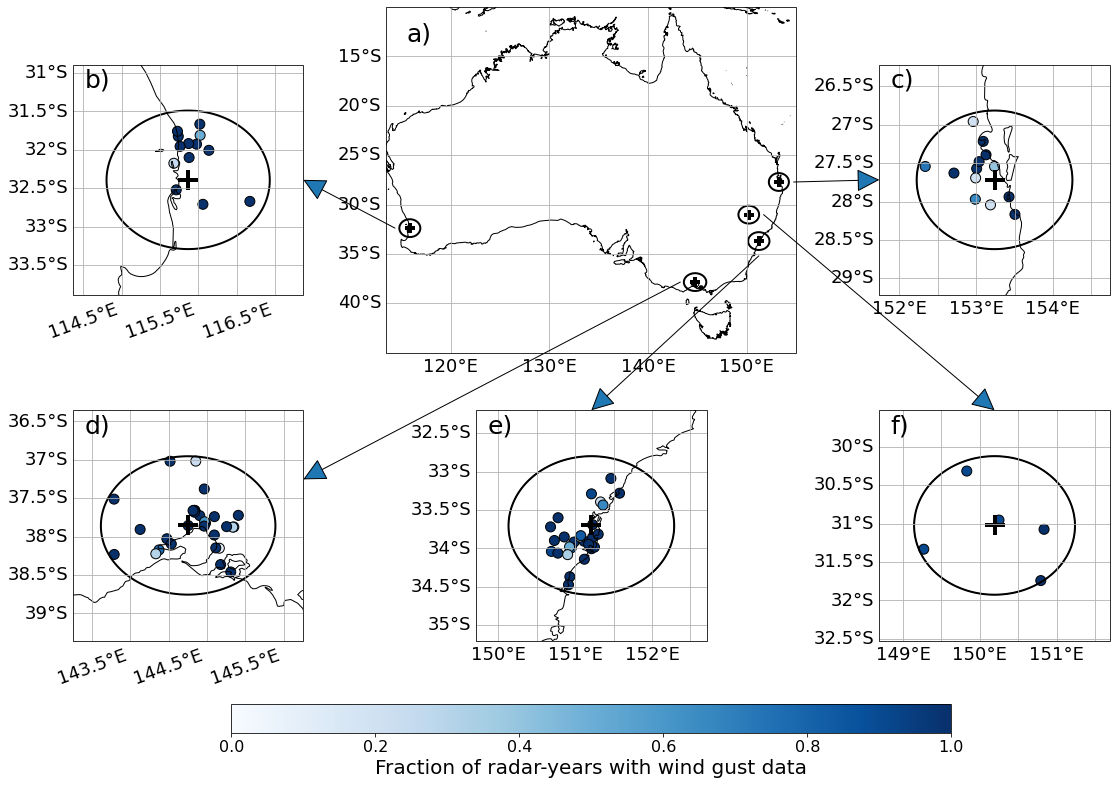

In [11]:
fig=plt.figure(figsize=[20,16])
b=0.6
dlon=1.5
dlat=1.5
lat2,lon2 = get_radar_latlon("2_20200101_20200131")
lat66,lon66 = get_radar_latlon("66_20200101_20200131")
lat69,lon69 = get_radar_latlon("69_20200101_20200131")
lat70,lon70 = get_radar_latlon("70_20200101_20200131")
lat71,lon71 = get_radar_latlon("71_20200101_20200131")


ax0 = plt.axes([0.3,b,0.3,0.3],projection=ccrs.PlateCarree())
ax0.set_xlim([113.5,155])
ax0.set_ylim([-45,-10])
plot_radar(ax0,[lon2,lon66,lon69,lon71,lon70],[lat2,lat66,lat69,lat71,lat70],ms=10)
ax0.coastlines("10m")
g=ax0.gridlines(draw_labels=True); g.xlabels_top=False; g.ylabels_right=False
g.xlabel_style={"size":18}
g.ylabel_style={"size":18}
ax0.text(0.05,0.9,"a)",transform=ax0.transAxes,size=25)


ax1 = plt.axes([0.07,0.65,0.2,0.2],projection=ccrs.PlateCarree())
ax1.set_xlim([lon70-dlon,lon70+dlon])
ax1.set_ylim([lat70-dlat,lat70+dlat])
ax1.coastlines("10m")
g=ax1.gridlines(draw_labels=True); g.xlabels_top=False; g.ylabels_right=False
plot_radar(ax1,[lon70],[lat70])
add_arrow(ax0,ax1,lon70,lat70,sub_y=True)
s=plot_stns(ax1, stns70, start_date=2013)
g.xlabel_style={"size":18,'rotation':20}
g.ylabel_style={"size":18}
ax1.text(0.05,0.9,"b)",transform=ax1.transAxes,size=25)

ax2 = plt.axes([0.07,0.35,0.2,0.2],projection=ccrs.PlateCarree())
ax2.set_xlim([lon2-dlon,lon2+dlon])
ax2.set_ylim([lat2-dlat,lat2+dlat])
ax2.coastlines("10m")
g=ax2.gridlines(draw_labels=True); g.xlabels_top=False; g.ylabels_right=False
plot_radar(ax2,[lon2],[lat2])
add_arrow(ax0,ax2,lon2,lat2,sub_y=True,sub_y_shift=0.2)
s=plot_stns(ax2, stns2, start_date=2008)
g.xlabel_style={"size":18,'rotation':20}
g.ylabel_style={"size":18}
ax2.text(0.05,0.9,"d)",transform=ax2.transAxes,size=25)

ax3 = plt.axes([0.35,0.35,0.2,0.2],projection=ccrs.PlateCarree())
plot_range_rings(lon71, lat71, 100, ax3)
ax3.set_xlim([lon71-dlon,lon71+dlon])
ax3.set_ylim([lat71-dlat,lat71+dlat])
ax3.coastlines("10m")
g=ax3.gridlines(draw_labels=True); g.xlabels_top=False; g.ylabels_right=False
plot_radar(ax3,[lon71],[lat71])
add_arrow(ax0,ax3,lon71,lat71,sub_y=False,y=False)
s=plot_stns(ax3, stns71, start_date=2009)
g.xlabel_style={"size":18}
g.ylabel_style={"size":18}
ax3.text(0.05,0.9,"e)",transform=ax3.transAxes,size=25)

ax4 = plt.axes([0.63,0.35,0.2,0.2],projection=ccrs.PlateCarree())
plot_range_rings(lon69, lat69, 100, ax4)
ax4.set_xlim([lon69-dlon,lon69+dlon])
ax4.set_ylim([lat69-dlat,lat69+dlat])
ax4.coastlines("10m")
g=ax4.gridlines(draw_labels=True); g.xlabels_top=False; g.ylabels_right=False
plot_radar(ax4,[lon69],[lat69])
add_arrow(ax0,ax4,lon69,lat69,sub_y=False,y=True,y_reverse=True)
s=plot_stns(ax4, stns69, start_date=2010)
g.xlabel_style={"size":18}
g.ylabel_style={"size":18}
ax4.text(0.05,0.9,"f)",transform=ax4.transAxes,size=25)

ax5 = plt.axes([0.63,0.65,0.2,0.2],projection=ccrs.PlateCarree())
plot_range_rings(lon66, lat66, 100, ax5)
ax5.set_xlim([lon66-dlon,lon66+dlon])
ax5.set_ylim([lat66-dlat,lat66+dlat])
ax5.coastlines("10m")
g=ax5.gridlines(draw_labels=True); g.xlabels_top=False; g.ylabels_right=False
plot_radar(ax5,[lon66],[lat66])
add_arrow(ax0,ax5,lon66,lat66,sub_y=True,y=True,y_reverse=True,sub_y_reverse=True)
s=plot_stns(ax5, stns66, start_date=2006)
g.xlabel_style={"size":18}
g.ylabel_style={"size":18}
ax5.text(0.05,0.9,"c)",transform=ax5.transAxes,size=25)

cax=plt.axes([0.2,0.27,0.5,0.025])
cb=plt.colorbar(s,orientation="horizontal",cax=cax)
cb.set_label("Fraction of radar-years with wind gust data",size=20)
cb.ax.tick_params(labelsize=16)

plt.savefig("/g/data/eg3/ab4502/figs/ExtremeWind/radar_locs.jpeg",dpi=800,bbox_inches="tight")

Melbourne
Brisbane (Mt Stapylton)
Namoi (Blackjack Mountain)
Perth (Serpentine)
Sydney (Terrey Hills)
Adelaide (Buckland Park)
Gympie
Emerald
Mount Isa
Cairns
Townsville (Hervey Range)
Weipa
Yarrawonga
Newcastle
Canberra (Captains Flat)
Kalgoorlie
Bairnsdale
Darwin (Berrimah)
Hobart (Mt Koonya)
Warruwi


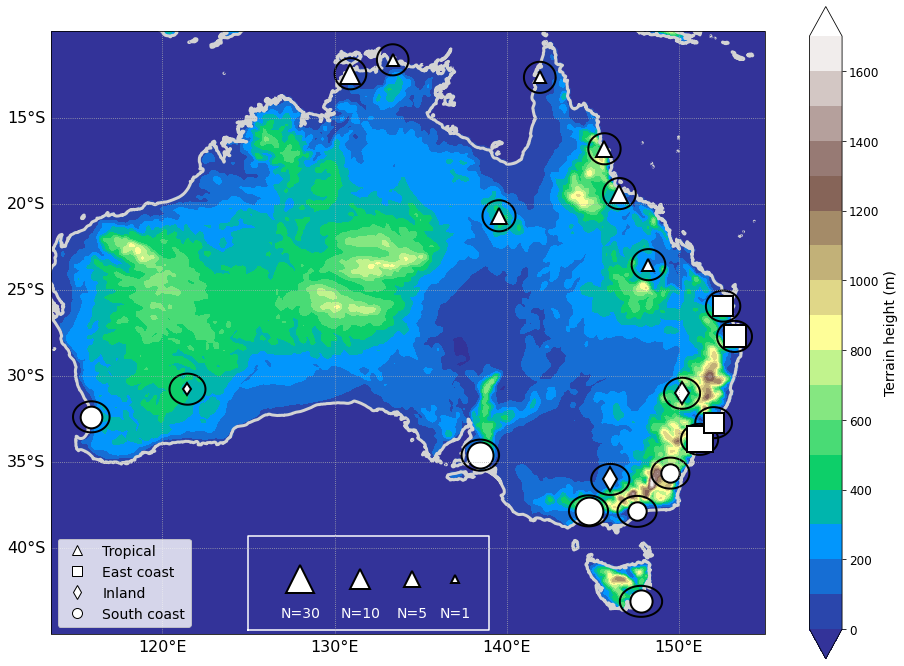

In [12]:
import geopandas
from affine import Affine
from rasterio import features

def transform_from_latlon(lat, lon):
    lat = np.asarray(lat)
    lon = np.asarray(lon)
    trans = Affine.translation(lon[0], lat[0])
    scale = Affine.scale(lon[1] - lon[0], lat[1] - lat[0])
    return trans * scale

def rasterize(shapes, coords, fill=np.nan, **kwargs):
    """Rasterize a list of (geometry, fill_value) tuples onto the given
    xray coordinates. This only works for 1d latitude and longitude
    arrays.
    """
    transform = transform_from_latlon(coords['lat'], coords['lon'])
    out_shape = (len(coords['lat']), len(coords['lon']))
    raster = features.rasterize(shapes, out_shape=out_shape,
                                fill=fill, transform=transform,
                                dtype=float, **kwargs)
    return xr.DataArray(raster, coords=coords, dims=('lat', 'lon'))

#rids = ["2","66","69","70","71","64","8","72","75","19","73","78","49","4","40","48","63","76","77","68"]

tropical_rids=["63","72","75","19","73","78",'77']
east_coast_rids=["4","8","66","71"]
inland_rids=["48","49","69"]
south_coast_rids=["70","2","68","64","76","40"]


plt.figure(figsize=[16,12])
ax0 = plt.axes(projection=ccrs.PlateCarree())
ax0.set_xlim([113.5,155])
ax0.set_ylim([-45,-10])
ax0.coastlines("10m",color="lightgray",lw=3)
g=ax0.gridlines(draw_labels=True,ylabel_style={"size":16},xlabel_style={"size":16},ls=":"); g.top_labels=False; g.right_labels=False

for i in np.arange(len(rids)):
    f=xr.open_dataset(glob.glob("/g/data/rq0/level_2/"+rids[i]+"/COLUMNMAXREFLECTIVITY/*.nc")[-1])
    lat0=f.attrs["origin_latitude"]
    lon0=f.attrs["origin_longitude"]    

    n_stations = float(station_stats(states[i],rids[i],start_year[i],return_dropped=False,print_stats=False))
    size = (np.log(n_stations+2) * 4.) * 2
    
    if rids[i] in tropical_rids:
        plot_radar(ax0,[lon0],[lat0],ms=size,color="white",marker="^",mec="k",mew=2)
    elif rids[i] in east_coast_rids:
        plot_radar(ax0,[lon0],[lat0],ms=size,color="white",marker="s",mec="k",mew=2)
    elif rids[i] in inland_rids:
        plot_radar(ax0,[lon0],[lat0],ms=size,color="white",marker="d",mec="k",mew=2)
    elif rids[i] in south_coast_rids:
        plot_radar(ax0,[lon0],[lat0],ms=size,color="white",marker="o",mec="k",mew=2)
    else:    
        plot_radar(ax0,[lon0],[lat0],ms=size,color="white",marker="^",mec="k",mew=2)
    
# f2 = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))
# f = geopandas.read_file("/home/548/ab4502/working/NRM_super_clusters/NRM_super_clusters.shp")
# #f = geopandas.read_file("/home/548/ab4502/working/NRM_sub_clusters//NRM_sub_clusters.shp")
# shapes = [(shape, n) for n, shape in enumerate(f.geometry)]
# xr.plot.contour(rasterize(shapes, {"lon":np.arange(113,155,0.05),"lat":np.arange(-45,-10,0.05)}),ax=ax0,x="lon",y="lat",
#                colors="k",levels=np.arange(20))    


barra = xr.open_dataset("/g/data/cj37/BARRA/BARRA_R/v1/static/topog-an-slv-PT0H-BARRA_R-v1.nc")
lons,lats = np.meshgrid(barra.longitude.values, barra.latitude.values)

topog = ax0.contourf(lons,lats,barra["topog"],cmap=plt.get_cmap("terrain"),levels=np.arange(0,1800,100),extend="both")
cb=plt.colorbar(topog)
cb.ax.tick_params(labelsize=12)
cb.set_label("Terrain height (m)",size=14)


#PLOT THE REFERENCE POINTS

n_stations = 30
point = (128,-41.8)
size = (np.log(n_stations+2) * 4.) * 2
plot_radar(ax0,[point[0]],[point[1]],ms=size,color="white",marker="^",mec="k",mew=2,lw=0)
ax0.text(point[0],point[1]-2,"N=30",ha="center",va="center",size=14,color="white")

n_stations = 10
point = (131.5,-41.8)
size = (np.log(n_stations+2) * 4.) * 2
plot_radar(ax0,[point[0]],[point[1]],ms=size,color="white",marker="^",mec="k",mew=2,lw=0)
ax0.text(point[0],point[1]-2,"N=10",ha="center",va="center",size=14,color="white")

n_stations = 5
point = (134.5,-41.8)
size = (np.log(n_stations+2) * 4.) * 2
plot_radar(ax0,[point[0]],[point[1]],ms=size,color="white",marker="^",mec="k",mew=2,lw=0)
ax0.text(point[0],point[1]-2,"N=5",ha="center",va="center",size=14,color="white")

n_stations = 1
point = (137,-41.8)
size = (np.log(n_stations+2) * 4.) * 2
plot_radar(ax0,[point[0]],[point[1]],ms=size,color="white",marker="^",mec="k",mew=2,lw=0)
ax0.text(point[0],point[1]-2,"N=1",ha="center",va="center",size=14,color="white")

ax0.plot([125,125,139,139,125],[-44.8,-44.8 + 5.5,-44.8 + 5.5,-44.8,-44.8],color="white")


custom_lines = [Line2D([0], [0], color="white", lw=0, marker="^", mec="k", ms=10),
                Line2D([0], [0], color="white", lw=0, marker="s", mec="k", ms=10),
                Line2D([0], [0], color="white", lw=0, marker="d", mec="k", ms=10),
                Line2D([0], [0], color="white", lw=0, marker="o", mec="k", ms=10)]
plt.legend(custom_lines, ["Tropical","East coast","Inland","South coast"], fontsize=14,loc=3)   

plt.savefig("/g/data/eg3/ab4502/figs/ExtremeWind/radar_locs2.jpeg",dpi=800,bbox_inches="tight")

In [13]:
#rid="2"
for rid in rids:
    f=xr.open_dataset(glob.glob("/g/data/rq0/level_2/"+rid+"/COLUMNMAXREFLECTIVITY/*.nc")[-1])
    lat0=f.attrs["origin_latitude"]
    lon0=f.attrs["origin_longitude"]

    #fnames = glob.glob("/g/data/rq0/level_2/"+rid+"/COLUMNMAXREFLECTIVITY/*")
    fnames = glob.glob("/g/data/rq0/level_2/"+rid+"/AZSHEAR/*")
    print(rid, np.min([int(fname.split('/')[-1].split("_")[1][0:4]) for fname in fnames]))

2 2007
66 2006
69 2010
70 2013
71 2009
64 2005
8 2007
72 2010
75 2012
19 2014
73 2015
78 2015
49 2006
4 2013
40 2013
48 2014
68 2014
63 2000
76 2012
77 2012


In [14]:
def get_aws_years(state, rid, start_year, max_stn_dist=100):
    #Read station info
    stn_df = read_stn_info(state)

    #Read TINT-created grid, for the purpose of getting the radar metadata
    f=xr.open_dataset(glob.glob("/g/data/rq0/level_2/"+rid+"/COLUMNMAXREFLECTIVITY/*.nc")[-1])
    lat0=f.attrs["origin_latitude"]
    lon0=f.attrs["origin_longitude"]
    
    #Calculate distance between radar and each station
    stn_df["dist_from_radar_km"] = latlon_dist(lat0, lon0, stn_df.lat.values, stn_df.lon.values)

    #Subset stations based on a max distance threshold, and having at least one year overlap with the radar data
    stn_df = stn_df[\
                        (stn_df.dist_from_radar_km <= max_stn_dist) &\
                        (stn_df.y2 >= int(start_year))]

    stn_df = stn_df[(np.in1d(stn_df.stn_no, return_drop_list(state),invert=True))]
    
    r_years = np.arange(start_year,2021)
    
    try:
        stn_years = np.sum([np.in1d(np.arange(stn_df.iloc[i].y1,stn_df.iloc[i].y2+1), r_years).sum() for i in np.arange(stn_df.shape[0])] * (stn_df["Y%"].astype(float)/100))
        return stn_years
    except:
        print(stn_df)


names = []
lons=[]
lats=[]
clim_type=[]
n_aws=[]
n_events=[]
#stn_years=[]
for i in np.arange(len(rids)):
    f=xr.open_dataset(glob.glob("/g/data/rq0/level_2/"+rids[i]+"/COLUMNMAXREFLECTIVITY/*.nc")[-1])
    lat0=f.attrs["origin_latitude"]
    lon0=f.attrs["origin_longitude"]    
    names.append(f.attrs["instrument_name"])
    lons.append(lon0)
    lats.append(lat0)
    if rids[i] in tropical_rids:
        clim_type.append("Tropical")
    elif rids[i] in east_coast_rids:
        clim_type.append("East coast")
    elif rids[i] in inland_rids:
        clim_type.append("Inland")
    elif rids[i] in south_coast_rids:
        clim_type.append("South coast")      
    n_stations = float(station_stats(states[i],rids[i],start_year[i],return_dropped=False,print_stats=False))
    n_aws.append(n_stations)
    n_events.append(remove_suspect_gusts(pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/points/"+rids[i]+"_scw_envs_df.csv")).shape[0])
    #stn_years.append(get_aws_years(states[i], rids[i], start_year[i], max_stn_dist=100))

Melbourne
Brisbane (Mt Stapylton)
Namoi (Blackjack Mountain)
Perth (Serpentine)
Sydney (Terrey Hills)
Adelaide (Buckland Park)
Gympie
Emerald
Mount Isa
Cairns
Townsville (Hervey Range)
Weipa
Yarrawonga
Newcastle
Canberra (Captains Flat)
Kalgoorlie
Bairnsdale
Darwin (Berrimah)
Hobart (Mt Koonya)
Warruwi


In [15]:
# import tqdm
# import datetime as dt
# def last_day_of_month(any_day):
#     # get close to the end of the month for any day, and add 4 days 'over'
#     next_month = any_day.replace(day=28) + dt.timedelta(days=4)
#     # subtract the number of remaining 'overage' days to get last day of current month, or said programattically said, the previous day of the first of next month
#     return next_month - dt.timedelta(days=next_month.day)

# stn_years=[]
# for i in np.arange(len(rids[0:2])):
#     rid=str(rids[i])
#     aws_years = 0
#     for year in tqdm.tqdm(np.arange(start_year[i],2021)):
#         for month in np.arange(1,13):
#             try:
#                 date = dt.datetime(int(year), int(month), 1)
#                 date2 = last_day_of_month(date)
#                 fid1 = date.strftime("%Y%m%d")
#                 fid2 = date2.strftime("%Y%m%d")
#                 aws_years = aws_years + (sum(1 for line in open("/g/data/eg3/ab4502/TINTobjects/"+ rid+"_"+fid1+"_"+fid2+"_aws.csv")) / (525600))
#             except:
#                 pass
#     stn_years.append(aws_years)

In [16]:
import tqdm
import datetime as dt
import subprocess
def last_day_of_month(any_day):
    # get close to the end of the month for any day, and add 4 days 'over'
    next_month = any_day.replace(day=28) + dt.timedelta(days=4)
    # subtract the number of remaining 'overage' days to get last day of current month, or said programattically said, the previous day of the first of next month
    return next_month - dt.timedelta(days=next_month.day)

stn_years=[]
for i in tqdm.tqdm(np.arange(len(rids))):
    rid=str(rids[i])
    aws_years = 0
    for year in np.arange(start_year[i],2021):
        for month in np.arange(1,13):
            try:
                date = dt.datetime(int(year), int(month), 1)
                date2 = last_day_of_month(date)
                fid1 = date.strftime("%Y%m%d")
                fid2 = date2.strftime("%Y%m%d")
                fname = "/g/data/eg3/ab4502/TINTobjects/"+ rid+"_"+fid1+"_"+fid2+"_aws.csv"
                aws_years = aws_years +\
                        (int(subprocess.check_output(["wc", "-l", fname]).decode("utf8").split()[0])-1) / (525960) #Divide by minutes per year including leap years
            except:
                pass
    stn_years.append(aws_years)

  0%|          | 0/20 [00:00<?, ?it/s]wc: /g/data/eg3/ab4502/TINTobjects/2_20100201_20100228_aws.csv: No such file or directory
wc: /g/data/eg3/ab4502/TINTobjects/2_20170901_20170930_aws.csv: No such file or directory
  5%|▌         | 1/20 [00:18<05:57, 18.83s/it]wc: /g/data/eg3/ab4502/TINTobjects/66_20060101_20060131_aws.csv: No such file or directory
wc: /g/data/eg3/ab4502/TINTobjects/66_20060201_20060228_aws.csv: No such file or directory
wc: /g/data/eg3/ab4502/TINTobjects/66_20060301_20060331_aws.csv: No such file or directory
wc: /g/data/eg3/ab4502/TINTobjects/66_20060401_20060430_aws.csv: No such file or directory
wc: /g/data/eg3/ab4502/TINTobjects/66_20060501_20060531_aws.csv: No such file or directory
 10%|█         | 2/20 [08:37<1:30:14, 300.83s/it]wc: /g/data/eg3/ab4502/TINTobjects/69_20100101_20100131_aws.csv: No such file or directory
wc: /g/data/eg3/ab4502/TINTobjects/69_20100201_20100228_aws.csv: No such file or directory
wc: /g/data/eg3/ab4502/TINTobjects/69_20100301_201

In [21]:
radar_df = pd.DataFrame({"Radar ID":np.array(rids).astype(int),
              "Radar name":names,
              "Radar archive start year":start_year,
              "Radar latitude":lats,
              "Radar longitude":lons,
              "Climate type":clim_type,
              "Number of AWS within 100 km":np.array(n_aws).astype(int),
              "AWS-years":np.array(stn_years).round(1),
              "Number of SCW events":np.array(n_events).astype(int),
              "Events per AWS-year":np.round(np.array(n_events) / np.array(stn_years),2)
             }).sort_values("Radar ID").set_index("Radar ID")

radar_df

,Radar name,Radar archive start year,Radar latitude,Radar longitude,Climate type,Number of AWS within 100 km,AWS-years,Number of SCW events,Events per AWS-year
Radar ID,,,,,,,,,
2,Melbourne,2008,-37.8553,144.7555,South coast,30,311.1,85,0.27
4,Newcastle,2013,-32.7298,152.0254,East coast,11,71.6,18,0.25
8,Gympie,2007,-25.9574,152.5768,East coast,9,85.8,20,0.23
19,Cairns,2014,-16.8170,145.6830,Tropical,5,31.2,0,0.00
40,Canberra (Captains Flat),2013,-35.6614,149.5122,South coast,8,63.1,10,0.16
48,Kalgoorlie,2014,-30.7843,121.4548,Inland,1,6.7,4,0.60
49,Yarrawonga,2006,-36.0296,146.0228,Inland,7,77.4,21,0.27
63,Darwin (Berrimah),2001,-12.4570,130.9250,Tropical,9,81.0,26,0.32
64,Adelaide (Buckland Park),2005,-34.6169,138.4689,South coast,24,254.1,26,0.10


0.25    0.115
0.50    0.205
0.75    0.335
Name: Events per AWS-year, dtype: float64


Text(0.5, 0, 'Location group')

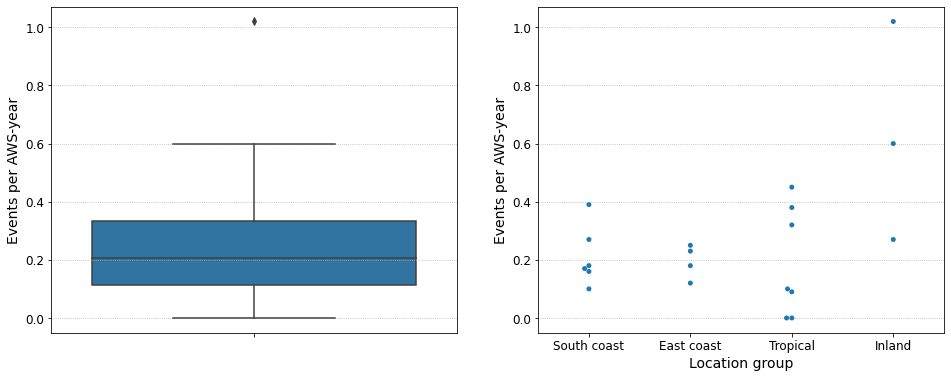

In [29]:
plt.figure(figsize=[16,6])

ax=plt.subplot(1,2,1)
sns.boxplot(data=radar_df,y="Events per AWS-year",color="tab:blue",ax=ax)
ax.grid(axis="y",ls=":")
ax.tick_params(labelsize=12)
ax.set_ylabel("Events per AWS-year",size=14)

ax=plt.subplot(1,2,2)
sns.swarmplot(data=radar_df,y="Events per AWS-year",x="Climate type",color="tab:blue",ax=ax)
ax.grid(axis="y",ls=":")

print(radar_df["Events per AWS-year"].quantile([0.25,0.5,0.75]))
ax.tick_params(labelsize=12)
ax.set_ylabel("Events per AWS-year",size=14)
ax.set_xlabel("Location group",size=14)

In [30]:
radar_df.to_latex("/g/data/eg3/ab4502/figs/ExtremeWind/table1.tex")

In [31]:
!cat /g/data/eg3/ab4502/figs/ExtremeWind/table1.tex

\begin{tabular}{llrrrlrrrr}
\toprule
{} &                  Radar name &  Radar archive start year &  Radar latitude &  Radar longitude & Climate type &  Number of AWS within 100 km &  AWS-years &  Number of SCW events &  Events per AWS-year \\
Radar ID &                             &                           &                 &                  &              &                              &            &                       &                      \\
\midrule
2        &                   Melbourne &                      2008 &        -37.8553 &         144.7555 &  South coast &                           30 &      311.1 &                    85 &                 0.27 \\
4        &                   Newcastle &                      2013 &        -32.7298 &         152.0254 &   East coast &                           11 &       71.6 &                    18 &                 0.25 \\
8        &                      Gympie &                      2007 &        -25.9574 &         152.5768 &   